In [1]:
options(warn = -1, tidyverse.quiet = T)

suppressPackageStartupMessages(library(tidyverse, warn.conflicts = F, quietly = T))
suppressPackageStartupMessages(library(cowplot, warn.conflicts = F, quietly = T))
suppressPackageStartupMessages(library(arrow, warn.conflicts = F, quietly = T))

options(readr.show_col_types = FALSE)

# Load data

In [2]:
do_maxgcp_comparison <- function(directory) {
    pcov <- read_tsv(directory + "/pcov/liability.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
        rename(phenotype1 = `...1`) %>%
        column_to_rownames("phenotype1") %>%
        as.matrix
    
    gcov <- read_tsv(directory + "/gcov/g_0.0.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
        rename(phenotype1 = `...1`) %>%
        column_to_rownames("phenotype1") %>%
        as.matrix
    
    pcov_fit <- read_tsv(directory + "/pcov/binary_m_0.05.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
        rename(phenotype1 = `...1`) %>%
        column_to_rownames("phenotype1") %>%
        as.matrix
    
    noisy_gcov <- read_tsv(directory + "/gcov/g_0.05.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
        rename(phenotype1 = `...1`) %>%
        column_to_rownames("phenotype1") %>%
        as.matrix
    
    original_h2 <- diag(gcov) / diag(pcov)
    
    beta <- solve(pcov_fit, gcov)
    beta <- sweep(beta, 2, FUN = "/", STATS = sqrt(diag(t(beta) %*% pcov %*% beta)))
    maxgcp_coher <- colSums(gcov * beta) / sqrt(diag(pcov))
    # maxgcp_rg <- colSums(gcov * beta) / sqrt(diag(gcov) * diag(t(beta) %*% gcov %*% beta))
    # maxgcp_h2 <- diag(t(beta) %*% gcov %*% beta) / diag(t(beta) %*% pcov %*% beta)
    
    beta_noisy <- solve(pcov_fit, noisy_gcov)
    beta_noisy <- sweep(beta_noisy, 2, FUN = "/", STATS = sqrt(diag(t(beta_noisy) %*% pcov %*% beta_noisy)))
    maxgcp_coher_noisy <- colSums(gcov * beta_noisy) / sqrt(diag(pcov))

    bind_rows(
            original_h2 %>% enframe %>% mutate(metric = "Naive"),
            maxgcp_coher_noisy %>% enframe %>% mutate(metric = "MaxGCP (noisy)"),
            maxgcp_coher %>% enframe %>% mutate(metric = "MaxGCP (optimal)"),
        ) %>%
        mutate(
            simulation = directory %>% str_extract("(?<=sim_)[0-9]+"),
            metric = metric %>% fct_inorder
        )
}

In [3]:
type_string <- "*sim_*_h_0.1_s_0.5_p_0.0"

maxgcp_comparison_df <- fs::dir_ls("data/simulations/", glob = type_string) %>%
    map(do_maxgcp_comparison) %>%
    list_rbind

maxgcp_comparison_df %>% write_parquet("plot_data/maxgcp-fit-coheritability.parquet")

maxgcp_comparison_df %>% head(2)

name,value,metric,simulation
<chr>,<dbl>,<fct>,<chr>
Trait_01,0.2348306,Naive,100
Trait_02,0.1046723,Naive,100


# Plot

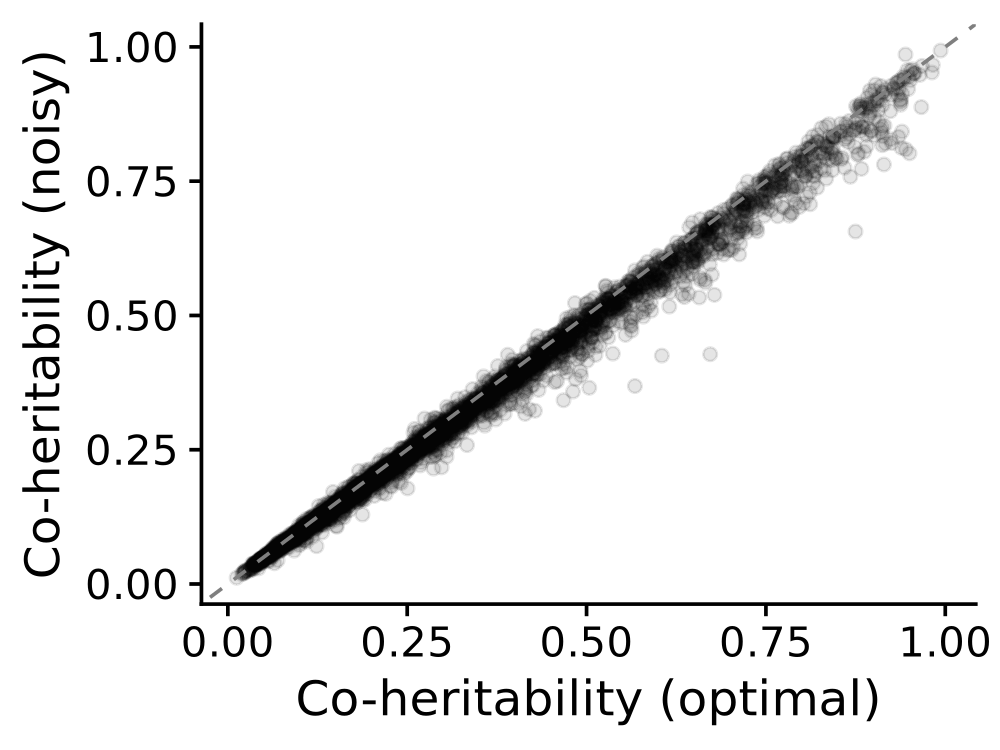

In [4]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 250)

optimal_vs_noisy_plot <- maxgcp_comparison_df %>%
    pivot_wider(names_from = metric, values_from = value) %>%
    ggplot(aes(x = `MaxGCP (optimal)`, y = `MaxGCP (noisy)`)) +
    geom_point(alpha = 0.1) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    theme_cowplot() +
    xlab("Co-heritability (optimal)") +
    ylab("Co-heritability (noisy)")

optimal_vs_noisy_plot

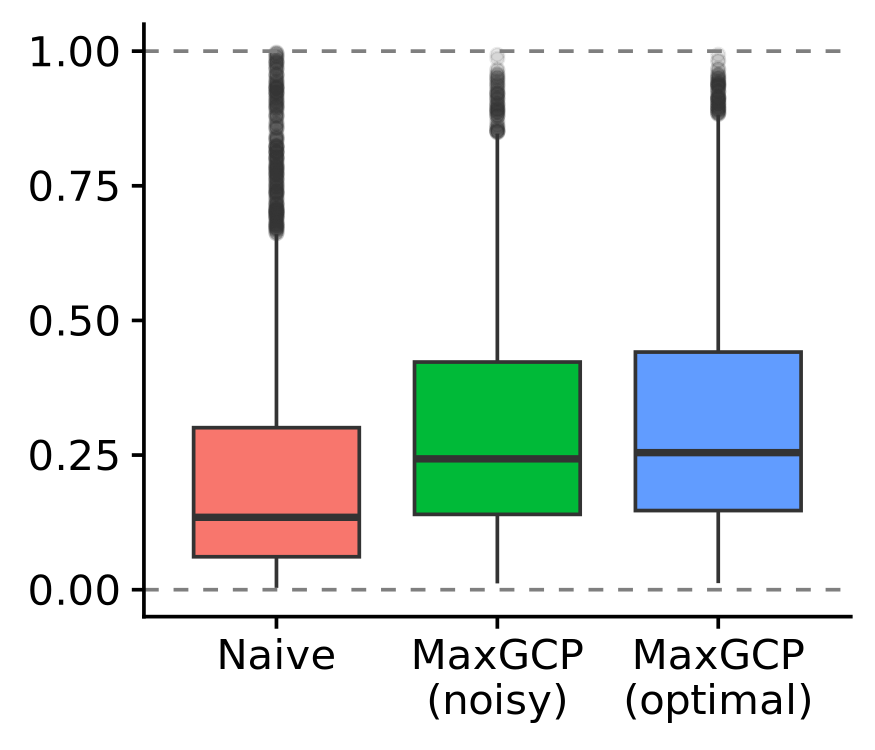

In [5]:
options(repr.plot.width = 3.5, repr.plot.height = 3, repr.plot.res = 250)

fit_quality_plot <- maxgcp_comparison_df %>%
    ggplot(aes(x = metric, y = value, fill = metric)) +
    geom_boxplot(outlier.alpha = 0.1) +
    geom_hline(yintercept = c(0, 1), linetype = "dashed", color = "grey50") +
    theme_cowplot() +
    theme(
        axis.title = element_blank(),
        legend.position = "none"
    ) +
    scale_x_discrete(labels = scales::wrap_format(10))

save_plot("img/maxgcp-coheritability-comparison.png", fit_quality_plot, base_width = 3.5, base_height = 3,
          dpi = 400, bg = "white")

fit_quality_plot